# Patch report: HR / LR / SR (MSResUNet) / SR (SwinIR) (+ red-box on HR full)

Логика (обновлено под ваш текущий пайплайн):

- **HR full**: 500×500 (grayscale).
- **LR raw**: 250×250 (grayscale), деградация x2 относительно HR.
- Для отчёта делаем ещё **LR_500** = bicubic(LR_raw → 500×500), чтобы удобно резать патчи теми же координатами, что и HR.

Полный прогон моделей:
- **SwinIR**: получает **сырой LR_raw 250×250** (без внешней нормализации; только перевод в tensor [0,1] и 3 канала), выдаёт **SR 500×500** (x2).
- **MSResUNet**: получает **LR_500 500×500** (mode "L", bicubic уже сделан заранее), выдаёт **SR 500×500**.

Отчёт: 16 строк (4×4), 5 колонок:
1) HR patch 125×125 → bicubic до 500×500  
2) LR patch 125×125 (из LR_500) → bicubic до 500×500  
3) MSResUNet SR patch 125×125 (crop из full SR 500×500) → bicubic до 500×500  
4) SwinIR SR patch 125×125 (crop из full SR 500×500) → bicubic до 500×500  
5) HR full 500×500 с красным квадратиком текущего патча


In [5]:
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Пути и параметры

**ВАЖНО:** поменяйте пути под ваш проект/окружение.  
- `HR_IMG_PATH` — HR png (500×500, grayscale или RGB).  
- `MSRESUNET_WEIGHTS`, `SWINIR_WEIGHTS` — веса моделей.  
- В `build_msresunet()` и `build_swinir()` импортируйте ваши классы и верните `nn.Module`.

In [6]:
# --- INPUTS ---
#HR_IMG_PATH = Path(r"C:\Users\Вячеслав\Documents\superresolution\DeepRockSR-2D\carbonate2D\carbonate2D_test_HR\3607.png")
#LR_IMG_PATH = Path(r"C:\Users\Вячеслав\Documents\superresolution\DeepRockSR-2D\carbonate2D\carbonate2D_test_LR_default_X2\3607x2.png")

HR_IMG_PATH = Path(r'C:\Users\Вячеслав\Documents\superresolution\beton_dataset\beton_test_HR\00035_013.png')
LR_IMG_PATH = Path(r'C:\Users\Вячеслав\Documents\superresolution\beton_dataset\beton_test_LR_default_X2\00035_013.png')

# --- MODEL WEIGHTS ---
MSRESUNET_WEIGHTS = Path(r"C:\Users\Вячеслав\Documents\superresolution\models\best_x2_ms_resunet.pt")
SWINIR_WEIGHTS = Path(r"C:\Users\Вячеслав\Documents\superresolution\models\001_classicalSR_DF2K_s64w8_SwinIR-M_x2.pth")

# --- OUTPUT ---
OUT_REPORT_PNG = Path("3607_swinir_vs_msresunet.png")

# --- PATCHING / SIZES ---
HR_SIZE = 500          # HR full size (для отчёта)
SCALE = 2              # x2 SR
PATCH_SIZE = 125
STRIDE = 125
GRID = 4               # 500/125 = 4

In [7]:
%cd C:\Users\Вячеслав\Documents\superresolution\modules

C:\Users\Вячеслав\Documents\superresolution\modules


['model']
HR: (500, 500) LR_raw: (250, 250)


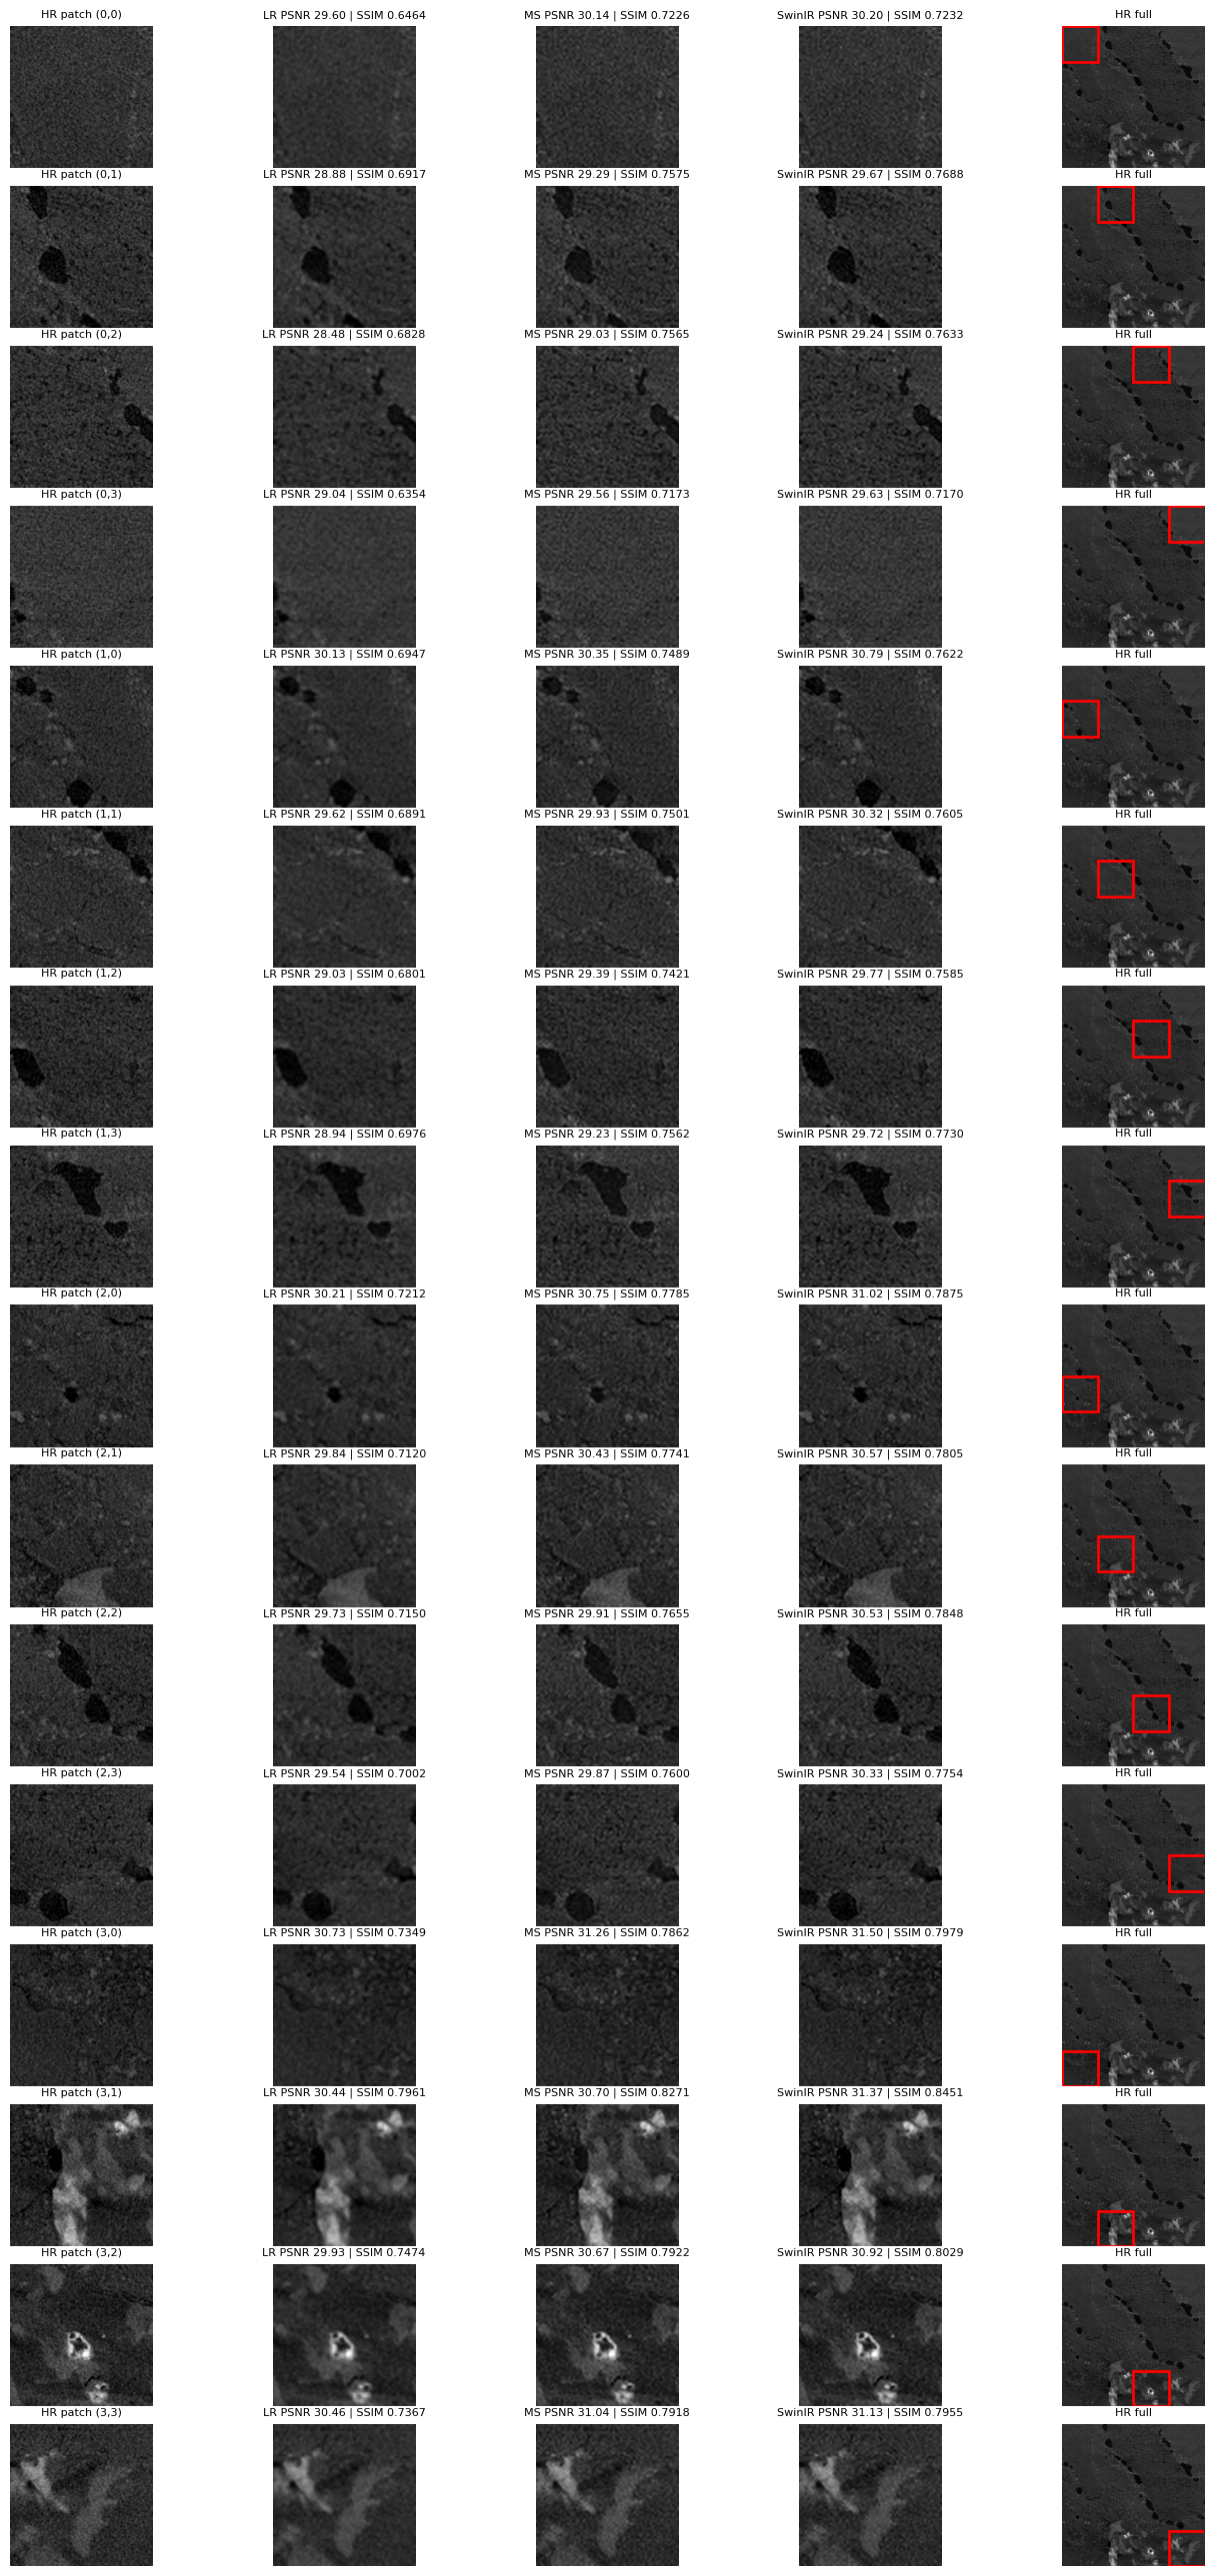

Saved: 3607_swinir_vs_msresunet.png


In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from network_swinir import SwinIR
from ms_resunet import MS_ResUNet

msresunet = MS_ResUNet().to(DEVICE)

msresunet_ckpt = torch.load(MSRESUNET_WEIGHTS, map_location="cpu")
print(list(msresunet_ckpt.keys()))

msresunet_dict = msresunet.load_state_dict(msresunet_ckpt['model'], strict=False)

# -------------------------
# 1) Load full images
# -------------------------
hr_full = Image.open(HR_IMG_PATH).convert("L").resize((HR_SIZE, HR_SIZE), Image.BICUBIC)

lr_raw = Image.open(LR_IMG_PATH).convert("L")                  # ожидаем 250×250
lr_raw_w, lr_raw_h = lr_raw.size
print("HR:", hr_full.size, "LR_raw:", lr_raw.size)

# LR_500: только для удобного кропа патчей и визуализации LR
lr_500 = lr_raw.resize((HR_SIZE, HR_SIZE), Image.BICUBIC)

# -------------------------
# 2) Run full SwinIR: LR_raw (250) -> SR (500)
# -------------------------
swinir = SwinIR(
        upscale=2,
        in_chans=3,
        img_size=64,
        window_size=8,
        img_range=1.0,
        depths=[6,6,6,6,6,6],
        embed_dim=180,
        num_heads=[6,6,6,6,6,6],
        mlp_ratio=2,
        upsampler="pixelshuffle",
        resi_connection="1conv",
    ).to(DEVICE)

swinir_ckpt = torch.load(SWINIR_WEIGHTS, map_location="cpu")
swinir_dict = swinir.load_state_dict(swinir_ckpt['params'])

lr_raw_np = np.array(lr_raw).astype(np.float32)                # 250×250
lr_raw_np3 = np.stack([lr_raw_np, lr_raw_np, lr_raw_np], axis=0)  # 3×250×250

x_swin = torch.from_numpy(lr_raw_np3).unsqueeze(0) / 255.0     # 1×3×250×250
x_swin = x_swin.to(DEVICE)

swinir.eval()
with torch.no_grad():
    y_swin = swinir(x_swin).clamp(0, 1)                        # 1×3×500×500

y_swin_gray = y_swin.mean(dim=1, keepdim=True)                 # 1×1×500×500

# -------------------------
# 3) Run full MSResUNet: LR_500 (500) -> SR (500)
# -------------------------
# NOTE: поправьте импорт, если у вас класс/файл называется иначе
msresunet = MS_ResUNet().to(DEVICE)
ms_state = torch.load(MSRESUNET_WEIGHTS, map_location="cpu")
msresunet.load_state_dict(ms_state['model'], strict=False)
msresunet.eval()

lr500_l = np.array(lr_500).astype(np.float32)                  # 500×500
x_ms = torch.from_numpy(lr500_l).unsqueeze(0).unsqueeze(0) / 255.0  # 1×1×500×500
x_ms = x_ms.to(DEVICE)

with torch.no_grad():
    y_ms = msresunet(x_ms).clamp(0, 1)                         # ожидаем 1×1×500×500

# -------------------------
# 4) Build report: 16 rows (one per patch) x 5 cols
# -------------------------
hr_full_np = np.array(hr_full).astype(np.float32) / 255.0      # 500×500
lr_full_np = np.array(lr_500).astype(np.float32) / 255.0       # 500×500

def up_to_500(arr2d, size=500):
    # arr2d: HxW float [0,1]
    t = torch.from_numpy(arr2d).unsqueeze(0).unsqueeze(0)
    t = F.interpolate(t, size=(size, size), mode="bicubic", align_corners=False)
    return t[0, 0].numpy()


def psnr(a, b):
    # a,b: HxW float [0,1]
    return float(peak_signal_noise_ratio(a, b, data_range=1.0))

def ssim(a, b):
    return float(structural_similarity(a, b, data_range=1.0))

# full SR outputs (500×500)
y_ms_np = y_ms[0, 0].detach().cpu().numpy()
y_swin_np = y_swin_gray[0, 0].detach().cpu().numpy()

num_rows = GRID * GRID  # 16
fig_h = num_rows * 1.6
fig_w = 5 * 2.8
fig, axes = plt.subplots(num_rows, 5, figsize=(fig_w, fig_h))

# axes can be 1D if num_rows==1; make sure it's always 2D [row, col]
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

for idx in range(num_rows):
    r = idx // GRID
    ccol = idx % GRID
    y0 = r * STRIDE
    x0 = ccol * STRIDE

    # 1) HR patch 125
    hr_patch = hr_full_np[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]
    hr_patch_500 = up_to_500(hr_patch, 500)

    # 2) LR patch 125 (из LR_500)
    lr_patch = lr_full_np[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]
    lr_patch_500 = up_to_500(lr_patch, 500)

    # 3-4) SR patches 125 (crop из full SR 500)
    sr_ms_patch = y_ms_np[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]
    sr_swin_patch = y_swin_np[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]

    sr_ms_500 = up_to_500(sr_ms_patch, 500)
    sr_swin_500 = up_to_500(sr_swin_patch, 500)

    row_axes = axes[idx, :]

    row_axes[0].imshow(hr_patch_500, cmap="gray", vmin=0, vmax=1)
    row_axes[0].set_title(f"HR patch ({r},{ccol})", fontsize=8)

    row_axes[1].imshow(lr_patch_500, cmap="gray", vmin=0, vmax=1)
    row_axes[1].set_title(f"LR PSNR {psnr(lr_patch, hr_patch):.2f} | SSIM {ssim(lr_patch, hr_patch):.4f}", fontsize=8)

    row_axes[2].imshow(sr_ms_500, cmap="gray", vmin=0, vmax=1)
    row_axes[2].set_title(f"MS PSNR {psnr(sr_ms_patch, hr_patch):.2f} | SSIM {ssim(sr_ms_patch, hr_patch):.4f}", fontsize=8)

    row_axes[3].imshow(sr_swin_500, cmap="gray", vmin=0, vmax=1)
    row_axes[3].set_title(f"SwinIR PSNR {psnr(sr_swin_patch, hr_patch):.2f} | SSIM {ssim(sr_swin_patch, hr_patch):.4f}", fontsize=8)

    row_axes[4].imshow(hr_full_np, cmap="gray", vmin=0, vmax=1)
    rect = patches.Rectangle((x0, y0), PATCH_SIZE, PATCH_SIZE,
                             linewidth=2, edgecolor="red", facecolor="none")
    row_axes[4].add_patch(rect)
    row_axes[4].set_title("HR full", fontsize=8)

    for ax in row_axes:
        ax.axis("off")

plt.tight_layout(pad=0.1)
fig.savefig(OUT_REPORT_PNG, dpi=150)
plt.show()
print("Saved:", OUT_REPORT_PNG)